In [104]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime, strptime
import os
import seaborn as sns

In [82]:
CL = 5

f = {f"{k}{i}": Value(dtype="string") for k in "ts" for i in range(CL)}
dataset = load_dataset("csv", 
                       data_files={split: f"../D0/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

aug_dataset = load_dataset("csv", 
                       data_files={split: f"../D2/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

In [83]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    convs = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": f"How does {examples[f's{CL-1}'][x]} feel at the end of the conversation?"}] + \
            [{"role": examples[f"s{i}"][x], "content": examples[f"t{i}"][x] + " "} for i in range(CL)], 
            tokenize=False)
        for x in range(len(examples["labels"]))
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)

    return encoding

def mask_all(examples):
    return {f"t{CL-1}": [tokenizer.mask_token for i in range(len(examples[f"t{CL-1}"]))]}

tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_aug_dataset = aug_dataset.map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_masked_dataset = dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_masked_aug_dataset = aug_dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/7681 [00:00<?, ? examples/s]

Map:   0%|          | 0/858 [00:00<?, ? examples/s]

Map:   0%|          | 0/1964 [00:00<?, ? examples/s]

Map:   0%|          | 0/7681 [00:00<?, ? examples/s]

Map:   0%|          | 0/858 [00:00<?, ? examples/s]

Map:   0%|          | 0/1964 [00:00<?, ? examples/s]

In [84]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [85]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))
# loss_fn = nn.CrossEntropyLoss()

class MaskedTrainer(Trainer):
    rng = np.random.default_rng(42)
    endl_token = tokenizer.encode('\n')[1]
    mask_token = tokenizer.mask_token_id
    eos_token = tokenizer.eos_token_id
    pad_token = tokenizer.pad_token_id

    mask_ratio = 0.5

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss
    
    def training_step(self, model, inputs):
        mask_idx = self.rng.choice(len(inputs["input_ids"]), int(self.mask_ratio * len(inputs["input_ids"])), replace=False)
        for i in mask_idx:
            s = (inputs["input_ids"][i] == self.endl_token).nonzero()[-2].item()
            e = (inputs["input_ids"][i] == self.eos_token).nonzero()[-1].item()

            inputs["input_ids"][i][s+2:s+11] = inputs["input_ids"][i][e-8:e+1].clone()
            inputs["input_ids"][i][s+1] = self.mask_token
            inputs["input_ids"][i][s+11:e+1] = self.pad_token
            inputs["attention_mask"][i][s+11:e+1] = 0

        
        return super().training_step(model, inputs)

In [86]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

c = get_checkpoint(20)
model = AutoModelForSequenceClassification.from_pretrained(c)

In [87]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=64,
    report_to="none",
)

trainer = MaskedTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [88]:
trainer.evaluate(tokenized_masked_dataset["test"])

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 2.0361075401306152,
 'eval_WA': 0.1614052953156823,
 'eval_UWA': 0.21772346179753999,
 'eval_miF1': 0.1614052953156823,
 'eval_maF1': 0.13499121444333068,
 'eval_wtF1': 0.17632865604665732,
 'eval_runtime': 4.6655,
 'eval_samples_per_second': 420.965,
 'eval_steps_per_second': 6.645}

In [89]:
predictions = trainer.predict(tokenized_masked_dataset["test"])

  0%|          | 0/31 [00:00<?, ?it/s]

In [90]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [91]:
preds

,t0,t1,t2,t3,t4,s0,s1,s2,s3,s4,labels,pred
0,Why do all you're coffee mugs have numbers on ...,Oh. That's so Monica can keep track. That way ...,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...",Mark,Rachel,Rachel,Ross,Frank,1,6
1,Oh. That's so Monica can keep track. That way ...,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?",Rachel,Rachel,Ross,Frank,Joey,5,6
2,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...",Rachel,Ross,Frank,Joey,Frank,1,6
3,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...","Yeah, yeah.",Ross,Frank,Joey,Frank,Ross,0,6
4,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...","Yeah, yeah.",Why can't I find that?,Frank,Joey,Frank,Ross,Joey,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1959,"I don't know what it is, I just can't take a g...","Oh, here's a great one.","Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",Chandler,Monica,Chandler,Monica,Phoebe,0,6
1960,"Oh, here's a great one.","Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,Monica,Chandler,Monica,Phoebe,Monica,1,6
1961,"Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,"Yeah that's great! Next to that, Chandler won'...",Chandler,Monica,Phoebe,Monica,Phoebe,0,6
1962,"I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,"Yeah that's great! Next to that, Chandler won'...",Chandler what do you say?,Monica,Phoebe,Monica,Phoebe,Monica,0,6


In [92]:
for i in range(8):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    print(str(sum(tp) / sum(preds["labels"] == i)) + ", ")

0.14819004524886878, 
0.2623762376237624, 
0.27692307692307694, 
0.19230769230769232, 
0.4628099173553719, 
0.10526315789473684, 
0.24489795918367346, 
0.049019607843137254, 


In [93]:
sum([0.2623762376237624, 
0.27692307692307694, 
0.19230769230769232, 
0.4628099173553719, 
0.10526315789473684, 
0.24489795918367346, 


])/6

0.2574296735480523

In [94]:
f1_score(preds["labels"], preds["pred"], average=None)[1:7]

array([0.22037422, 0.11803279, 0.04878049, 0.19787986, 0.11609499,
       0.06      ])

In [95]:
np.bincount(preds["labels"])

array([884, 202,  65,  26, 121, 209,  49, 408])

In [96]:
counts = np.bincount(preds["labels"])[1:7]
(f1_score(preds["labels"], preds["pred"], average=None)[1:7] * counts / sum(counts)).sum()

0.1556597194737067

In [156]:
n = [0] * 8

for i in range(1000):
    abcd = np.random.choice([1], len(preds["pred"]))
    for i in range(8):

        tp = (preds["labels"] == i) & (abcd == i)
        tn = (preds["labels"] != i) & (abcd != i)

        # print((sum(tp) + sum(tn))/len(preds))
        # print(str(sum(tp) / sum(preds["labels"] == i)) + ", ")
        n[i] += sum(tp) / sum(preds["labels"] == i)

In [157]:
[i / 1000 for i in n]

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [97]:
for i in range(8):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    print(str(sum(tp) / sum(preds["labels"] == i)) + ", ")

0.14819004524886878, 
0.2623762376237624, 
0.27692307692307694, 
0.19230769230769232, 
0.4628099173553719, 
0.10526315789473684, 
0.24489795918367346, 
0.049019607843137254, 


In [98]:
dataset["train"].features["labels"].names

['neutral',
 'joy',
 'sadness',
 'fear',
 'anger',
 'surprise',
 'disgust',
 'non-neutral']

In [151]:
sum([0.2623762376237624, 
0.27692307692307694, 
0.19230769230769232, 
0.4628099173553719, 
0.10526315789473684, 
0.24489795918367346, 
])/6

0.2574296735480523

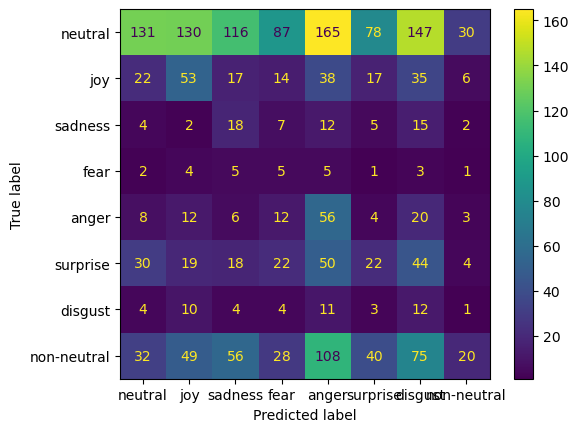

In [99]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)

<Axes: >

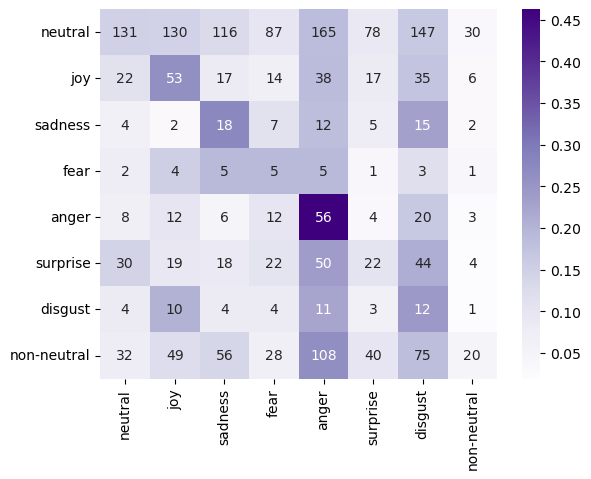

In [158]:
label_names = dataset["train"].features["labels"].names
cm = confusion_matrix(preds["labels"], preds["pred"])
norm_cm = cm / cm.sum(1)[:, np.newaxis]
df_cm = pd.DataFrame(norm_cm, index=label_names, columns=label_names)
sns.heatmap(df_cm, annot=cm, fmt="", cmap="Purples")

In [67]:
from transformers import pipeline

model.to("cpu")
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [70]:
text_inputs = [
    [
        "My car just broke.", 
        "Mine's broken too. We can't go anywhere.", 
        "What about his?", 
        "Also broken. We're stuck.",
        "<mask>",
    ], [
        "Let's go party", 
        "Sure!", 
        "Are you ready?", 
        "I'm all ready. Let's go!",
        "<mask>",
    ],
]

role_names = ["Chandler", "Monica"]
convs = [
    tokenizer.apply_chat_template(
        [{"role": "system", "content": f"How does {role_names[0]} feel at the end of the conversation?"}] + \
        [{"role": role_names[i % 2], "content": x + " "} for i, x in enumerate(m)], 
        tokenize=False)
    for m in text_inputs
]

pipe(convs)

[{'label': 'LABEL_6', 'score': 0.2181878536939621},
 {'label': 'LABEL_1', 'score': 0.31182801723480225}]

In [17]:
outputs = torch.softmax(model(**tokenizer(convs, return_tensors="pt", padding=True)).logits, dim=-1)

In [18]:
outputs

tensor([[0.1224, 0.1031, 0.2255, 0.1441, 0.0402, 0.0841, 0.2272, 0.0534],
        [0.1363, 0.3419, 0.0624, 0.1004, 0.0487, 0.1515, 0.0873, 0.0716]],
       grad_fn=<SoftmaxBackward0>)

In [19]:
raise Exception

Exception: 

In [73]:
p = []

for i in range(21, 41):
    c = get_checkpoint(i)
    model = AutoModelForSequenceClassification.from_pretrained(c)

    training_args = TrainingArguments(
        output_dir="/tmp/tmp_trainer",
        per_device_eval_batch_size=64,
        report_to="none",
    )

    trainer = MaskedTrainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,

    )

    predictions = trainer.predict(tokenized_masked_dataset["test"])

    scores = compute_metrics(predictions[:2])

    preds = pd.DataFrame(dataset["test"])
    preds["pred"] = np.argmax(predictions[0], axis=1)

    abc = []
    for i in range(8):
        tp = (preds["labels"] == i) & (preds["pred"] == i)
        tn = (preds["labels"] != i) & (preds["pred"] != i)

        # print((sum(tp) + sum(tn))/len(preds))
        abc.append(sum(tp) / sum(preds["labels"] == i))

    p.append(f"WA: {scores['WA']} UWA: {scores['UWA']} f: {sum(abc[1:7])/6}")

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [72]:
for x in p:
    print(x)

WA: 0.10641547861507128 UWA: 0.125 f: 0.16666666666666666
WA: 0.10641547861507128 UWA: 0.125 f: 0.16666666666666666
WA: 0.11354378818737271 UWA: 0.1499021313614615 f: 0.19986950848194865
WA: 0.3070264765784114 UWA: 0.14040018464976248 f: 0.08344207626504278
WA: 0.1894093686354379 UWA: 0.16911741909529254 f: 0.17339084738095314
WA: 0.2505091649694501 UWA: 0.181900295252089 f: 0.14279767873732532
WA: 0.24439918533604887 UWA: 0.18731235459725384 f: 0.14457760904571001
WA: 0.2235234215885947 UWA: 0.19432374063076657 f: 0.19304754155494872
WA: 0.15274949083503056 UWA: 0.20465422347985882 f: 0.23830718987862523
WA: 0.20162932790224034 UWA: 0.20134811471704267 f: 0.21928743098521733
WA: 0.22810590631364563 UWA: 0.20142669355047305 f: 0.20069562156654328
WA: 0.20723014256619143 UWA: 0.2109034300799241 f: 0.22146978208746038
WA: 0.1955193482688391 UWA: 0.20497393263532132 f: 0.21717741043181107
WA: 0.1985743380855397 UWA: 0.19871712546388132 f: 0.2095263030317814
WA: 0.18686354378818737 UWA: 0.

In [74]:
for x in p:
    print(x)

WA: 0.15173116089613034 UWA: 0.20965217834446345 f: 0.24374563950201966
WA: 0.17362525458248473 UWA: 0.20693725073824532 f: 0.2313273448757298
WA: 0.164969450101833 UWA: 0.20063811508036855 f: 0.2212316647527086
WA: 0.15376782077393075 UWA: 0.19701048406777022 f: 0.22299361676607674
WA: 0.16242362525458248 UWA: 0.19987809302093035 f: 0.21968411397260298
WA: 0.16395112016293278 UWA: 0.19381883093360058 f: 0.20852566095319694
WA: 0.17973523421588594 UWA: 0.19718608673137306 f: 0.20773630065942758
WA: 0.17973523421588594 UWA: 0.20477229193579943 f: 0.22630398100238314
WA: 0.159877800407332 UWA: 0.19477445708791533 f: 0.21533024645407314
WA: 0.16395112016293278 UWA: 0.19902453710201196 f: 0.2211227111083638
WA: 0.17158859470468432 UWA: 0.20119324009780698 f: 0.2182953608543912
WA: 0.1690427698574338 UWA: 0.20619507621176952 f: 0.22681842237989583
WA: 0.16547861507128309 UWA: 0.20416624618509563 f: 0.2262814906399566
WA: 0.17209775967413443 UWA: 0.20793276500611996 f: 0.2306122135727653
WA: